In [1]:
try:
    get_ipython().run_line_magic('load_ext', 'autoreload')
    get_ipython().run_line_magic('autoreload', '2')
except ModuleNotFoundError:
    print("autoreload extension not available. Continuing without autoreload.")

autoreload extension not available. Continuing without autoreload.


In [2]:
from templates import *
from templates_cls import *
from experiment_classifier import ClsModel

E:\enanalytica_shanghai\diffae\metrics.py:10: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [3]:
#device = 'cuda:3'
device = 'cuda:0'
conf = ffhq256_autoenc()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu',
                   weights_only=False)
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Seed set to 0


Model params: 160.69 M


In [4]:
cls_conf = ffhq256_autoenc_cls()
cls_model = ClsModel(cls_conf)
state = torch.load(f'checkpoints/{cls_conf.name}/last.ckpt',
                    map_location='cpu',weights_only=False)
print('latent step:', state['global_step'])
cls_model.load_state_dict(state['state_dict'], strict=False);
cls_model.to(device);

Seed set to 0


loading pretrain ... 130M
step: 1563562
loading latent stats ...
latent step: 9375


In [5]:
# data = conf.make_dataset()
# batch = data[10]['img'][None]

In [6]:
data = ImageDataset('imgs_align', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
#batch = data[1]['img'][None]
print(data[0])
batch = data[0]['img'][None]

{'img': tensor([[[ 0.5843,  0.5843,  0.5765,  ...,  0.4039,  0.3961,  0.3882],
         [ 0.5922,  0.5765,  0.5843,  ...,  0.3647,  0.3725,  0.3725],
         [ 0.6000,  0.5922,  0.6078,  ...,  0.3098,  0.3176,  0.3255],
         ...,
         [-0.4667, -0.3333, -0.2314,  ..., -0.5922, -0.5608, -0.4824],
         [-0.5137, -0.4118, -0.2784,  ..., -0.5294, -0.5843, -0.4902],
         [-0.5451, -0.4667, -0.3412,  ..., -0.4980, -0.5216, -0.4353]],

        [[ 0.5765,  0.5765,  0.5765,  ...,  0.6000,  0.6000,  0.6000],
         [ 0.5843,  0.5686,  0.5765,  ...,  0.5765,  0.5843,  0.5765],
         [ 0.5843,  0.5686,  0.5843,  ...,  0.5608,  0.5608,  0.5529],
         ...,
         [-0.0980, -0.0275, -0.0353,  ..., -0.4824, -0.4588, -0.3961],
         [-0.1294, -0.0745, -0.0353,  ..., -0.4275, -0.4745, -0.4039],
         [-0.1451, -0.1059, -0.0588,  ..., -0.4196, -0.4353, -0.3412]],

        [[ 0.6235,  0.6235,  0.6235,  ...,  0.6784,  0.6863,  0.6863],
         [ 0.6314,  0.6157,  0.6235, 

In [7]:
cond = model.encode(batch.to(device))
xT = model.encode_stochastic(batch.to(device), cond, T=250)

E:\enanalytica_shanghai\diffae\diffusion\base.py:306: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(self.conf.fp16):


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.8994055..5.932181].


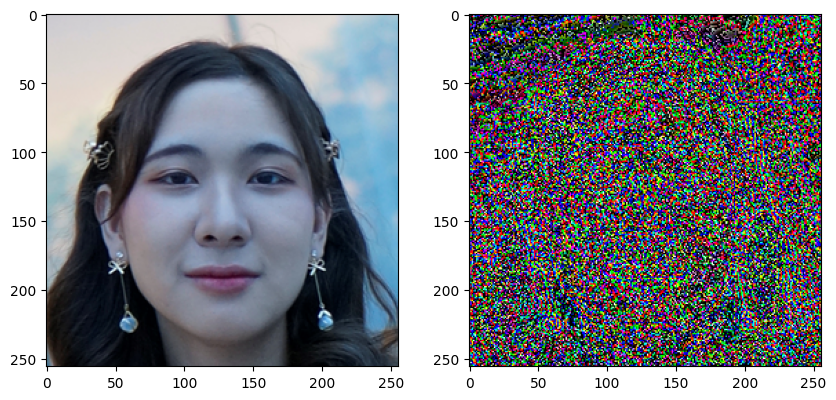

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(xT[0].permute(1, 2, 0).cpu())

In [9]:
print(CelebAttrDataset.id_to_cls)

['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']


In [10]:
cls_id = CelebAttrDataset.cls_to_id['Wavy_Hair']

In [11]:
cond2 = cls_model.normalize(cond)
cond2 = cond2 + 0.3 * math.sqrt(512) * F.normalize(cls_model.classifier.weight[cls_id][None, :], dim=1)
cond2 = cls_model.denormalize(cond2)

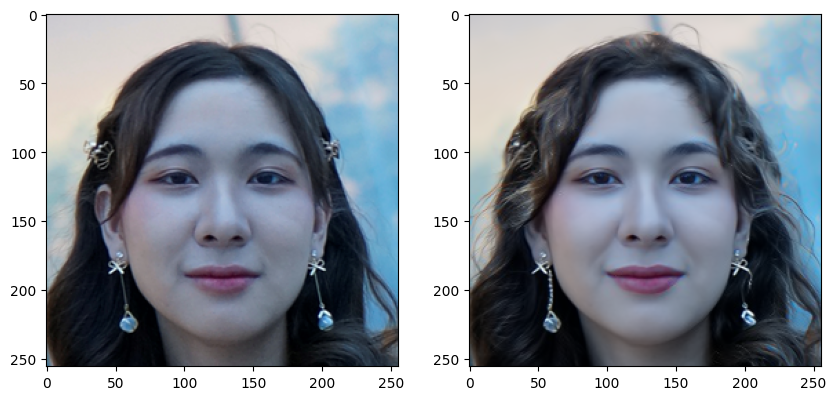

In [12]:
import matplotlib.pyplot as plt
# torch.manual_seed(1)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
img = model.render(xT, cond2, T=100)
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(img[0].permute(1, 2, 0).cpu())
plt.savefig('imgs_manipulated/compare.png')

In [13]:
from torchvision.utils import *
save_image(img[0], 'imgs_manipulated/output.png')